In [3]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [67]:
import torch
from pilotnet import PilotNet, get_transform
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [8]:
net = PilotNet()
net.load_state_dict(torch.load('../checkpoints/net.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
net

PilotNet(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1164, bias=True)
  (fc2): Linear(in_features=1152, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)

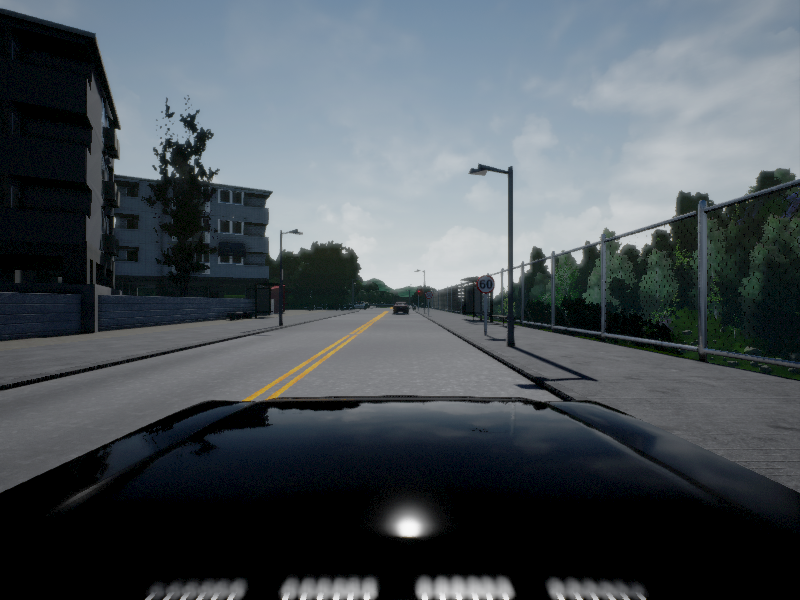

In [21]:
im = Image.open('../data/2020-10-14--09-02-25/train/episode_0003/RGBCenter/000140.png')
im

In [22]:
t = get_transform()

In [25]:
t(im).size()

torch.Size([3, 66, 200])

In [26]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [27]:
net.conv1.register_forward_hook(get_activation('conv1'))


In [31]:
output = net(t(im).unsqueeze(0))

In [32]:
conv1_act = activation['conv1']

In [33]:
conv1_act.size()

torch.Size([1, 24, 31, 98])

In [51]:
act = conv1_act.squeeze()

In [57]:
act.size(0)

24

In [68]:
mt = transforms.Compose([transforms.CenterCrop((160,320)),transforms.Resize((66,200))])

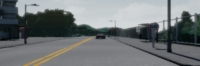

In [69]:
mt(im)

In [75]:
r,c = 6,4

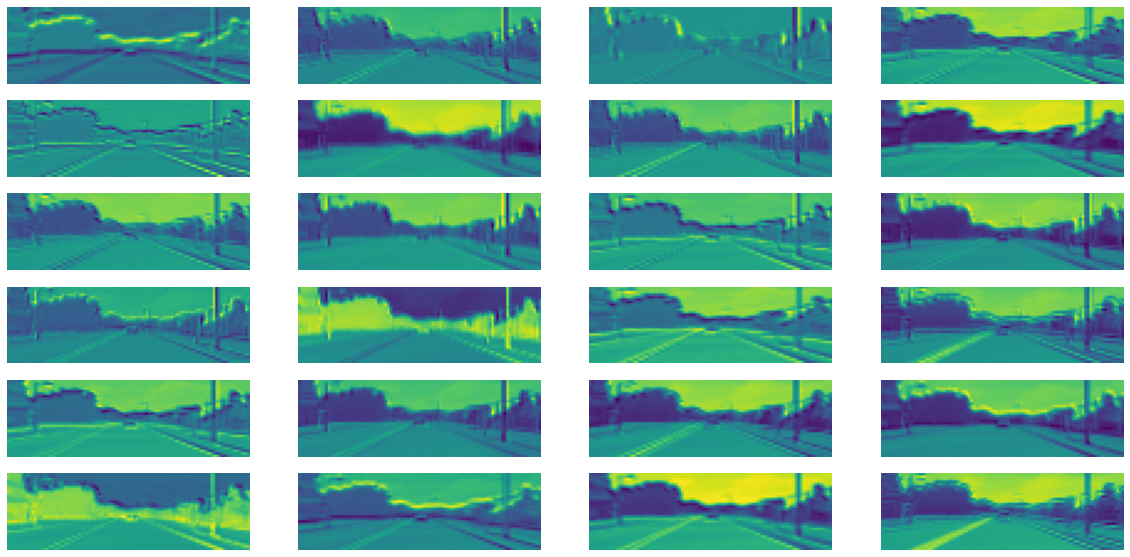

In [85]:
fig, axarr = plt.subplots(r,c, sharex='all', sharey='all', figsize=(20, 10))
plt.axis('off')
for i in range(r):
    for j in range(c):
        axarr[i][j].set_axis_off()
        axarr[i][j].imshow(act[4 * i + j])